#### Import Libraries

In [4]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, GridSearchCV

from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from umap import UMAP


## Question 1

In [5]:
customers = pd.read_csv('./bankloan.csv')
print(customers.shape)
customers.head()

(212999, 53)


,Row ID,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,...,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,Unnamed: 50,36months,60months
0,1.0,60516983,64537751,20000,20000,36 months,12.29,667.06,C,C1,...,INDIVIDUAL,NaN,NaN,0,0,52303,41000,NaN,1.0,0.0
1,2.0,60187139,64163931,11000,11000,36 months,12.69,369.00,C,C2,...,INDIVIDUAL,NaN,NaN,0,332,175731,13100,NaN,1.0,0.0
2,3.0,60356453,64333218,7000,7000,36 months,9.99,225.84,B,B3,...,INDIVIDUAL,NaN,NaN,0,0,202012,16300,NaN,1.0,0.0
3,4.0,59955769,63900496,10000,10000,36 months,10.99,327.34,B,B4,...,INDIVIDUAL,NaN,NaN,0,0,108235,34750,NaN,1.0,0.0
4,5.0,58703693,62544456,9550,9550,36 months,19.99,354.87,E,E4,...,INDIVIDUAL,NaN,NaN,0,0,45492,14100,NaN,1.0,0.0


In [ ]:
profile = ProfileReport(customers, title='Customers Profile Report')
profile.to_file("customer_profile_report.html")

## Question 2

1. Η μέση τιμή του ποσού που αιτούνται οι πελάτες για δάνειο είναι 15257.966€. Αντίστοιχα, το μέγιστο ποσό αίτησης είναι 35000€ και το ελάχιστο 1000€.


2. Για αρχή πρέπει να αφαιρέσουμε τις μεταβλητές όπου είναι κάποιου είδους id. Τέτοιες μεταβλητές είναι οι `Row ID`, `id`, και `member_id`. 

    Στη συνέχεια, θα διαγράψουμε τις μεταβλητές που η πλειοψηφία των δεδομένων τους είναι NULL, όπως οι `months_since_last_delinq`,`mths_since_last_major_derog`, `annual_inc_joint`, `dti_joint`, `Unnamed: 50`, `36months`, `60months`.

    Επίσης, εάν 2 μεταβλητές είναι highly correlated (term/36months-60months), μπορούμε να αφαιρέσουμε την μία απτίς δύο για να μειώσουμε την πολυπλοκότητα του μοντέλου και να αποφύγουμε κάποια πιθανή υπερπροσαρμογή του μοντέλου. Οπότε, θα κρατήσουμε το term, διότι δεν έχει null values όπως οι 36months και 60months(99%), και θα κάνουμε mapping των τιμών του. 

    Τέλος, οι μεταβλητές που έχουν ίδια τιμή σχεδόν για όλες τις εγγραφές δεν περιέχουν πληροφορία χρήσιμη για το μοντέλο μας, για αυτό τις αφαιρούμε. Τέτοια μεταβλητή είναι η `application_type`.
    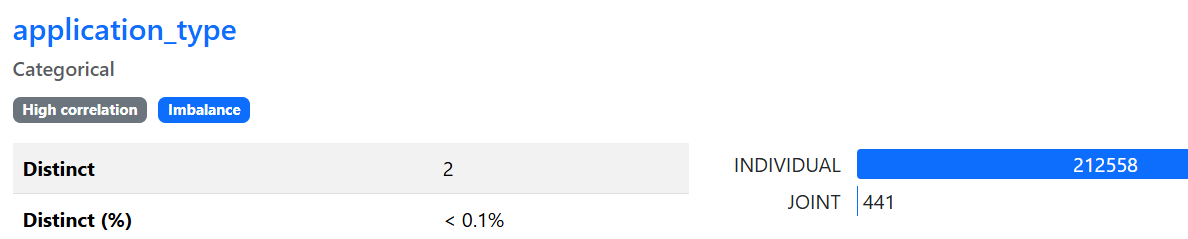


In [6]:
customers_cln = customers.drop(columns=['Row ID','id','member_id','emp_title','emp_length','grade','issue_d','title','delinq_2yrs','earliest_cr_line',
                                        'verification_status','purpose','mths_since_last_delinq','collection_recovery_fee','last_pymnt_d','next_pymnt_d',
                                        'last_credit_pull_d','collections_12_mths_ex_med','mths_since_last_major_derog','application_type',
                                        'annual_inc_joint','dti_joint','acc_now_delinq','tot_coll_amt','36months','60months','Unnamed: 50','int_rate'])
customers_cln.shape

(212999, 25)

3. Για αρχή, θα διαγράψουμε τις εγγραφές που έχουν missing values για κάποια μεταβλητή που κρατήσαμε, εφόσον αυτές είναι λίγες. Στη συνέχεια, στις μεταβλητές όπου είναι κατηγορικές, θα εφαρμόσουμε mapping για να πάρουν αριθμητικές τιμές.

##### Delete NULL values

In [7]:
customers_cln = customers_cln.dropna(subset=['revol_util'])
customers_cln.shape

(212917, 25)

##### Mapping

In [8]:
customers_cln.dtypes

loan_amnt                int64
funded_amnt              int64
term                    object
installment            float64
sub_grade               object
home_ownership          object
annual_inc             float64
loan_status             object
dti                    float64
inq_last_6mths           int64
open_acc                 int64
pub_rec                  int64
revol_bal                int64
revol_util             float64
total_acc                int64
initial_list_status     object
out_prncp              float64
total_pymnt            float64
total_rec_prncp        float64
total_rec_int          float64
total_rec_late_fee     float64
recoveries             float64
last_pymnt_amnt        float64
tot_cur_bal              int64
total_rev_hi_lim         int64
dtype: object

Από τις παραπάνω στήλες, όποια έχει τύπο `object` και δεν θα την χρησιμοποιήσουμε για την target στήλη (π.χ. `sub_grade`), θα χρειαστεί να την επεξεργαστούμε.

In [9]:
print(customers_cln['term'].unique())
print(customers_cln['home_ownership'].unique())
print(customers_cln['loan_status'].unique())
print(customers_cln['initial_list_status'].unique())

[' 36 months' ' 60 months']
['OWN' 'MORTGAGE' 'RENT' 'ANY']
['Charged Off' 'Current']
['w' 'f']


In [10]:
term_labels = {" 36 months":36, " 60 months":60}
home_ownership_labels = {"OWN":1, "MORTGAGE":2, "RENT":3, "ANY":4}
loan_status_labels = {"Charged Off":0, "Current":1}
initial_list_status_labels = {"w":1, "f":2}

customers_cln['term'] = customers_cln['term'].map(term_labels)
customers_cln['home_ownership'] = customers_cln['home_ownership'].map(home_ownership_labels)
customers_cln['loan_status'] = customers_cln['loan_status'].map(loan_status_labels)
customers_cln['initial_list_status'] = customers_cln['initial_list_status'].map(initial_list_status_labels)


In [11]:
print(customers_cln['term'].unique())
print(customers_cln['home_ownership'].unique())
print(customers_cln['loan_status'].unique())
print(customers_cln['initial_list_status'].unique())

[36 60]
[1 2 3 4]
[0 1]
[1 2]


##### 4. Create target column
Εφόσον το εάν κάποιος παίρνει δάνειο κρίνεται από το `sub_grade` του, και αν ανήκει στην κατηγορία Α(Α1,Α2,Α3) ή Β1,Β2, τότε για να φτιάξουμε την target στήλη, που θα είναι 1-θα πάαρει δάνειο ή 0-δεν θα πάρει δάνειο, θα χρειαστεί να κάνουμε το αντίστοιχο mapping στην στήλη `sub_grade` 

In [12]:
eligible_grade = ['A1','A2','A3','A4','A5','B1','B2']
customers_cln['is_eligible'] = customers_cln['sub_grade'].isin(eligible_grade).astype(int)
customers_cln = customers_cln.drop(columns=['sub_grade'])
customers_cln

,loan_amnt,funded_amnt,term,installment,home_ownership,annual_inc,loan_status,dti,inq_last_6mths,open_acc,...,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,tot_cur_bal,total_rev_hi_lim,is_eligible
0,20000,20000,36,667.06,1,65000.00,0,20.72,1,25,...,0.00,0.00,0.00,0.00,0.0,0.0,0.00,52303,41000,0
1,11000,11000,36,369.00,2,40000.00,0,24.57,0,13,...,0.00,10043.49,9942.67,100.81,0.0,0.0,10059.00,175731,13100,0
2,7000,7000,36,225.84,2,32000.00,0,32.41,1,18,...,0.00,221.96,167.56,54.40,0.0,0.0,225.84,202012,16300,0
3,10000,10000,36,327.34,2,48000.00,0,30.98,2,18,...,0.00,315.13,235.76,79.37,0.0,0.0,327.34,108235,34750,0
4,9550,9550,36,354.87,3,32376.00,0,32.54,3,9,...,0.00,333.66,195.78,137.88,0.0,0.0,354.87,45492,14100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212994,20000,20000,36,677.07,3,120000.00,1,9.04,0,6,...,17147.54,4120.02,2852.46,1267.56,0.0,0.0,700.00,21474,5400,0
212995,6000,6000,36,197.95,3,25000.00,1,2.21,2,3,...,5284.89,1010.88,715.11,295.77,0.0,0.0,197.95,2176,4200,0
212996,18000,18000,60,468.82,3,120000.00,1,7.76,1,4,...,16869.83,2793.73,1130.17,1663.56,0.0,0.0,468.82,8414,15300,0
212997,7050,7050,36,246.51,2,18614.27,1,21.53,0,12,...,6090.46,1472.95,959.54,513.41,0.0,0.0,246.51,159660,26800,0


##### 5. Discretization of Loan Amount
Θα κάνουμε διακριτοποίηση της στήλης `loan_amnt` σε όσα bins χρειάζεται, έτσι ώστε το 15% των εγγραφών που είναι εκεί μέσα, να έχουν `is_eligible==1`.

In [13]:
customers_cln['loan_amnt_bin'] = pd.cut(customers_cln['loan_amnt'], bins=5)
bin_proportions = customers_cln.groupby('loan_amnt_bin')['is_eligible'].mean()
print(round(bin_proportions*100, 2))

loan_amnt_bin
(966.0, 7800.0]       29.05
(7800.0, 14600.0]     31.52
(14600.0, 21400.0]    28.89
(21400.0, 28200.0]    31.78
(28200.0, 35000.0]    14.70
Name: is_eligible, dtype: float64


C:\Users\panos\AppData\Local\Temp\ipykernel_6720\3282824869.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_proportions = customers_cln.groupby('loan_amnt_bin')['is_eligible'].mean()


Παρατηρούμε ότι εφόσον χωρίσαμε τα δεδομένα μας σε 5 bins, το bin που είναι πιο κοντά στο 15% που θέλουμε, είναι το **(28200.0, 35000.0]**.
Δηλαδή για το **14.70%** των πελατών, που έκαναν αίτηση δανείου για αυτό το εύρος χρημάτων, έγινε δεκτό το αίτημά τους. 

In [14]:
customers_cln = customers_cln.drop(columns=['loan_amnt_bin'])

## Question 3

1. Θα κανονικοποιήσουμε τις συνεχείς μεταβλητές με τη χρήση του z-score, έτσι ώστε οποιαδήποτε ακραία τιμή να μην επηρεάσει τα δεδομένα μας και τα συμπιέσει σε πολύ μικρό διάστημα μετά από μία απλή κανονικοποίηση. Δεν θα κανονικοποιήοσυμε όμως και τις μεταβλητές που κάναμε mapping ή έχουν διακριτές τιμές, γιατί παρόλο που οι τιμές τους είναι αριθμητικές προδίδουν μία κατηγορία η κάθε μία, και όχι συνεχή τιμή.

In [15]:
customers_cln['loan_amnt']

0         20000
1         11000
2          7000
3         10000
4          9550
          ...  
212994    20000
212995     6000
212996    18000
212997     7050
212998     3500
Name: loan_amnt, Length: 212917, dtype: int64

In [16]:
customers_cln[['loan_amnt','funded_amnt','installment','annual_inc',
 'dti', 'open_acc', 'pub_rec', 'revol_bal','revol_util','total_acc','out_prncp',
 'total_pymnt','total_rec_prncp', 'total_rec_int','total_rec_late_fee',
 'recoveries', 'last_pymnt_amnt','tot_cur_bal','total_rev_hi_lim']] = customers_cln[['loan_amnt','funded_amnt','installment','annual_inc',
                                                                      'dti', 'open_acc', 'pub_rec', 'revol_bal','revol_util','total_acc','out_prncp',
                                                                      'total_pymnt','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries',
                                                                      'last_pymnt_amnt','tot_cur_bal','total_rev_hi_lim']].apply(zscore)

In [17]:
customers_cln['loan_amnt']

0         0.550595
1        -0.494554
2        -0.959064
3        -0.610681
4        -0.662939
            ...   
212994    0.550595
212995   -1.075191
212996    0.318339
212997   -0.953257
212998   -1.365510
Name: loan_amnt, Length: 212917, dtype: float64

##### 2. Split to train-test sets

In [18]:
x = np.array(customers_cln.drop(columns=['is_eligible']))
y = np.array(customers_cln['is_eligible'])

In [19]:
test_size=0.30
seed=42

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed, stratify=y)
x_train.shape,y_train.shape, x_test.shape,y_test.shape

((149041, 24), (149041,), (63876, 24), (63876,))

##### 3. Train Classifier

Διαλέγουμε να εκπαιδεύσουμε ένα RandomForest ταξινομητή, διότι τα δεδομένα μας είναι αρκετά περιπλόκα για έναν Logistic Regression Classifier, και δεν είναι γραμμικά διαχωρήσιμα στα οποία είναι καλά τέτοιoυ είδους μοντέλα. Επίσης χρησιμοποιούμε Random Forest αντί για ένα Decision Tree, γιατί είναι μία εξελιγμένη μορφή του και είναι λιγότερο ευάλωτο στο overfitting. Τέλος, δεν χρησιμοποιούμε SVM μοντέλο, διότι είναι πάρα πολλά τα δεδομένα μας και θα πάρει πολύ ώρα για να εκπαιδευτεί.

In [20]:
forest = RandomForestClassifier()
forest.fit(x_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
ypred  = forest.predict(x_test)

accuracy = round(accuracy_score(y_test,ypred)*100, 2)
precision = round(precision_score(y_test,ypred)*100, 2)
recall = round(recall_score(y_test,ypred)*100, 2)
f1 = round(f1_score(y_test,ypred)*100, 2)

print(f"Model's accuracy score in test set: {accuracy}")
print(f"Model's precision score in test set: {precision}")
print(f"Model's recall score in test set: {recall}")
print(f"Model's f1-score in test set: {f1}")

Model's accuracy score in test set: 97.09
Model's precision score in test set: 97.17
Model's recall score in test set: 92.58
Model's f1-score in test set: 94.82


##### Apply GridSearch

In [23]:
parameters = {'criterion':('gini','entropy'), 'max_depth':[3,5,7,10], 'min_samples_split':[2,3,4]}
best_forest = GridSearchCV(forest, parameters, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
best_forest.fit(x_train, y_train)

,estimator,RandomForestClassifier()
,param_grid,"{'criterion': ('gini', ...), 'max_depth': [3, 5, ...], 'min_samples_split': [2, 3, ...]}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


##### 4. Fine tuned model evaluation
Η σημαντικότερη μετρική για το πρόβλημά μας είναι η ακρίβεια(precision), διότι δείχνει πόσοι από τους πελάτες που κρίθηκαν κατάλληλοι για δάνειο ήταν όντως κατάλληλοι, και όσο μεγαλύτερη ακρίβεια έχουμε τόσους λιγότερους πελάτες που κρίθηκαν κατάλληλοι ,αλλά εντέλει δεν ήταν, θα έχουμε. Αυτό είναι σημαντικό διότι εάν η τράπεζα δανίσει σε κάποιον που δεν θα πληρώσει το χρέος του, θα χάσει λεφτά.

In [24]:
ypred2  = best_forest.predict(x_test)

ft_accuracy = round(accuracy_score(y_test,ypred2)*100, 2)
ft_precision = round(precision_score(y_test,ypred2)*100, 2)
ft_recall = round(recall_score(y_test,ypred2)*100, 2)
ft_f1 = round(f1_score(y_test,ypred2)*100, 2)

print(f"Fine tuned model's accuracy score in test set: {ft_accuracy}")
print(f"Fine tune model's precision score in test set: {ft_precision}")
print(f"Fine tune model's recall score in test set: {ft_recall}")
print(f"Fine tuned model's f1-score in test set: {ft_f1}")

Fine tuned model's accuracy score in test set: 90.61
Fine tune model's precision score in test set: 93.19
Fine tune model's recall score in test set: 72.68
Fine tuned model's f1-score in test set: 81.67


## Question 4

##### 1. Check 15 most important features of Random Forest 

In [25]:
forest = RandomForestClassifier()
forest.fit(x_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [26]:
ypred  = forest.predict(x_test)

accuracy = round(accuracy_score(y_test,ypred)*100, 2)
precision = round(precision_score(y_test,ypred)*100, 2)
recall = round(recall_score(y_test,ypred)*100, 2)
f1 = round(f1_score(y_test,ypred)*100, 2)

print(f"Model's accuracy score in test set: {accuracy}")
print(f"Model's precision score in test set: {precision}")
print(f"Model's recall score in test set: {recall}")
print(f"Model's f1-score in test set: {f1}")

Model's accuracy score in test set: 97.11
Model's precision score in test set: 97.07
Model's recall score in test set: 92.74
Model's f1-score in test set: 94.86


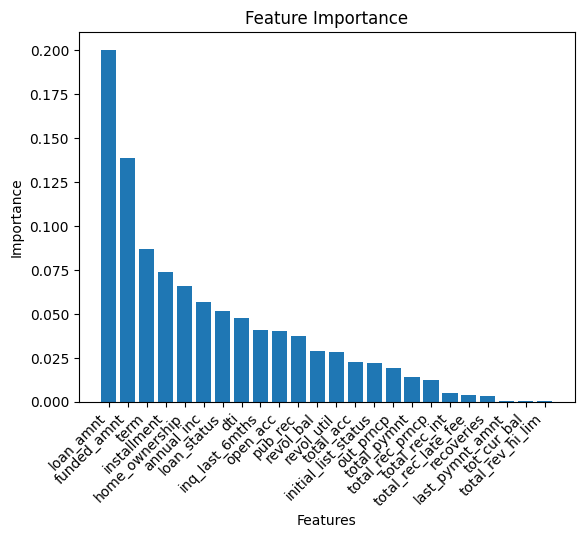

In [27]:
importances = forest.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_idx]

plt.bar([customers_cln.columns[i] for i in range(len(importances))], sorted_importances)
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

Στο πρώτο run είδα ότι η στήλη `int_rate` επηρεάζει σημαντικά το μοντέλο μας (~90%), οπότε αυτή είναι που προδίδει και την κατηγορία του πελάτη. Έτσι την αφαίρεσα και ξαναέτρεξα το μοντέλο, γιατί έπαιρνα 99% ποσοστό ακρίβειας με αυτή τη στήλη, και πήρα τα παραπάνω δεδομένα.

Από το ραβδόγραμμα βλέπουμε ότι τα 15 πιο σημαντικά χαρακτηριστικά, κατά σειρά, είναι:
1. loan_amnt
2. funded_amnt
3. term
4. installment
5. home_ownership
6. annual_inc
7. loan_status
8. dti
9. inq_last_6mths
10. open_acc
11. pub_rec
12. revol_bal
13. revol_util
14. total_acc
15. initial_list_status

##### 2. Correlation Matrix

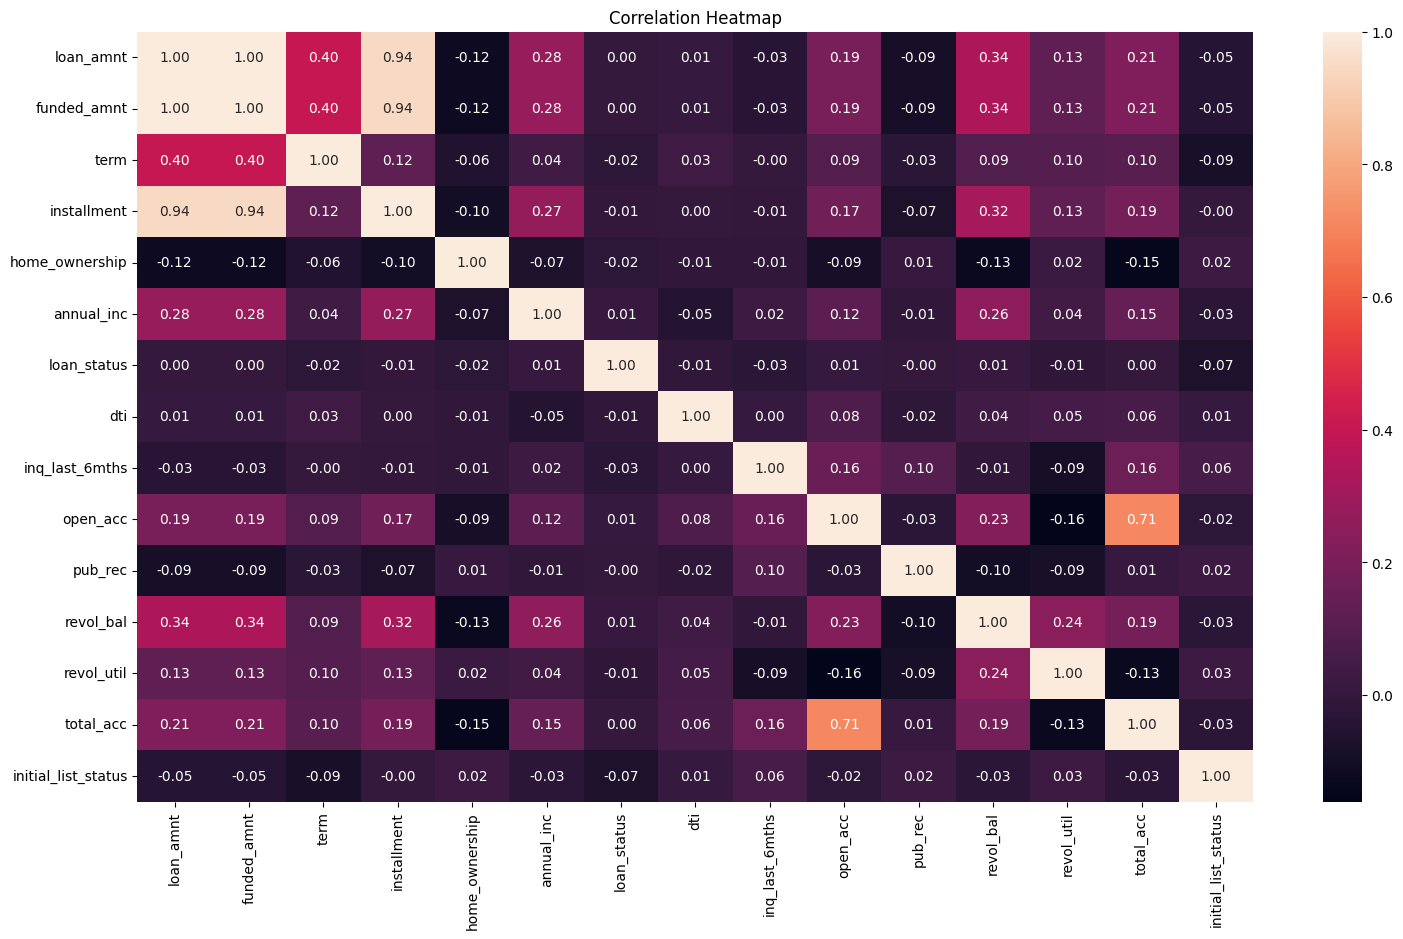

In [28]:
correlation = customers_cln[['loan_amnt','funded_amnt','term','installment','home_ownership','annual_inc',
                             'loan_status','dti','inq_last_6mths','open_acc','pub_rec','revol_bal',
                             'revol_util','total_acc','initial_list_status']].corr()

plt.figure(figsize=(18,10))
sns.heatmap(correlation, annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

##### 3. Keep necessary featues only

Παρατηρούμε ότι τα ζεύγη χαρακτηριστικών 'open_acc'/'total_acc', 'loan_amnt'/'funded_amnt' και 'installment'/'loan_amnt'+'funded_amnt' έχουν υψηλή συσχέτιση μεταξύ τους οπότε θα κρατήσουμε το ένα από αυτά μόνο.

In [29]:
final_data = customers_cln[['loan_amnt','term','home_ownership','annual_inc',
                        'loan_status','dti','inq_last_6mths','pub_rec','revol_bal',
                        'revol_util','total_acc','initial_list_status','is_eligible']]

In [30]:
x2 = np.array(final_data.drop(columns=['is_eligible']))
y2 = np.array(final_data['is_eligible'])

In [31]:
test_size=0.30
seed=42

x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=test_size, random_state=seed, stratify=y2)
x2_train.shape,y2_train.shape, x2_test.shape,y2_test.shape

((149041, 12), (149041,), (63876, 12), (63876,))

In [32]:
forest = RandomForestClassifier()
forest.fit(x2_train, y2_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [33]:
ypred3  = forest.predict(x2_test)

final_accuracy = round(accuracy_score(y2_test,ypred3)*100, 2)
final_precision = round(precision_score(y2_test,ypred3)*100, 2)
final_recall = round(recall_score(y2_test,ypred3)*100, 2)
final_f1 = round(f1_score(y2_test,ypred3)*100, 2)

print(f"Final model's accuracy score in test set: {final_accuracy}")
print(f"Final model's precision score in test set: {final_precision}")
print(f"Model's recall score in test set: {recall}")
print(f"Final model's f1-score in test set: {final_f1}")

Final model's accuracy score in test set: 79.42
Final model's precision score in test set: 69.17
Model's recall score in test set: 92.74
Final model's f1-score in test set: 58.97


## Question 5

##### 1. Load MNIST dataset

In [34]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [35]:
x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

##### 2. Standard Scaling

In [36]:
scaler = StandardScaler()
scaler.fit(x_train)

,copy,True
,with_mean,True
,with_std,True


In [37]:
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

x_train_scaled.shape, x_test_scaled.shape

((60000, 784), (10000, 784))

##### 3. Apply Principal Component Analysis (PCA) & Train KNN model

Εάν εφαρμόσουμε την fit_transform και σε train και σε test data, θα υπάρξει διαρροή της πληροφορίας από το test set δεδομένων που θα εκπαιδευτεί πάνω σε αυτή το μοντέλο μας, και έτσι θα μειωθεί η απόδοσή του ή θα κάνει overfitting.

In [38]:
pca = PCA(n_components=300)
x_train_final = pca.fit_transform(x_train_scaled)
x_test_final = pca.transform(x_test_scaled)

x_train_final.shape, x_test_final.shape

((60000, 300), (10000, 300))

In [39]:
k_neighbors = [5,15,51,101]
for k in k_neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_final,y_train)

    ypred = knn.predict(x_test_final)
    accuracy = round(accuracy_score(y_test,ypred)*100, 2)

    print(f"KNN model's accuracy for k={k}: {accuracy}")

KNN model's accuracy for k=5: 94.97
KNN model's accuracy for k=15: 94.36
KNN model's accuracy for k=51: 92.73
KNN model's accuracy for k=101: 91.58


##### 4. Dimensionality Reduction with Linear Discriminent Analysis (LDA)

In [40]:
lda = LinearDiscriminantAnalysis(n_components=2)
x_train_lda = lda.fit_transform(x_train_final, y_train)
x_test_lda = lda.transform(x_test_final)

x_train_lda.shape, x_test_lda.shape

((60000, 2), (10000, 2))

Text(0.5, 0, 'Feature 1')

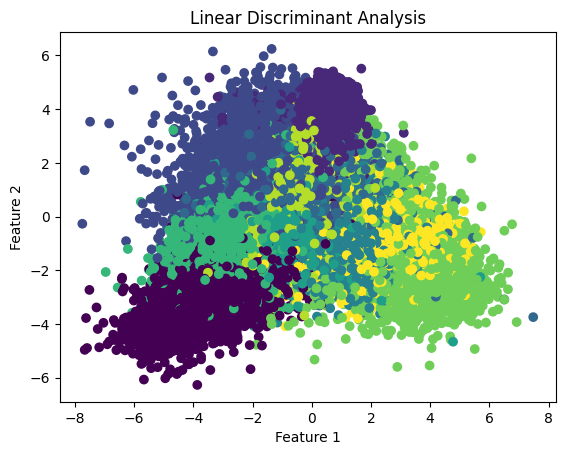

In [41]:
plt.scatter(x_train_lda[:,0], x_train_lda[:,1], c=y_train)
plt.title('Linear Discriminant Analysis')
plt.ylabel('Feature 2')
plt.xlabel('Feature 1')

##### 5.  Dimensionality Reduction with UMAP

In [42]:
umap = UMAP(n_components=2)
x_train_umap = umap.fit_transform(x_train_final, y_train)
x_test_umap = umap.transform(x_test_final)

x_train_umap.shape, x_test_umap.shape

((60000, 2), (10000, 2))

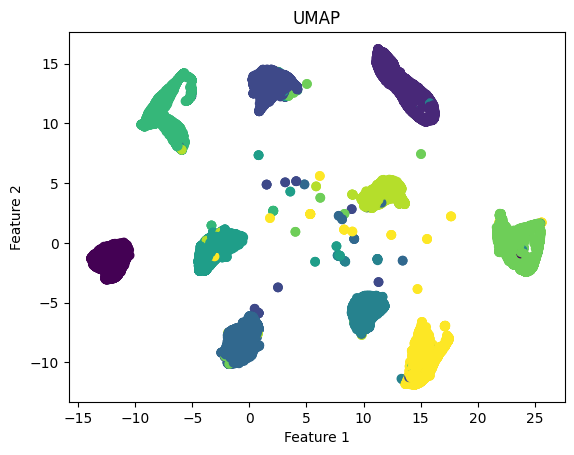

In [43]:
plt.scatter(x_train_umap[:,0], x_train_umap[:,1], c=y_train)
plt.title('UMAP')
plt.ylabel('Feature 2')
plt.xlabel('Feature 1')
plt.show()

Φαίνεται ξεκάθαρα ότι οι 10 κλάσεις μας, έχουν διαχωριστεί πολύ πιο ξεκάθαρα με τη χρήση της μεθόδου UMAP απότι με την LDA.